如果为每一个像素都生成锚框的话，锚框的数量就太多了。

## 多尺度锚框

以每个像素点为中心，生成多个锚框的话，锚框数量会大大增加。想要减少锚框的数量并不困难，比如可以在输入图像中采样一小部分像素，以其为中心生成锚框。

此外，我们可以生成不同数量和不同大小的锚框，比如较小的目标在图像上出现的可能性更多样。如，$1 \times 1$, $1 \times 2$和$2 \times 2$的目标可以分别以4， 2和1种可能的方式出现在$2 \times 2$的图像上。因此，当使用较小的锚框检测较小的物体时，我们可以采样更多的区域，而对于较大的物体，我们可以采样较小的区域。



In [1]:
import torch
import matplotlib.pyplot as plt

img = plt.imread('../images/tinyzqh.jpg')
h, w = img.shape[:2]
h, w

(480, 480)

在特征图(`fmap`)上生成锚框(`anchors`), 每个单位(像素)作为锚框的中心，特征图就是卷积层的输出。

In [2]:
def multibox_prior(data, sizes, ratios):
    """
    生成以每个像素为中心，具有不同形状的锚框
    data: 输入数据。
    size: 缩放比。
    ratios: 高宽比。
    """
    in_height, in_width = data.shape[-2:]  # 最后两个维度获取数据的高和宽。
    device, num_sizes, num_ratios = data.device, len(sizes), len(ratios)
    
    boxes_per_pixel = (num_sizes + num_ratios -1)  # 每个像素具有的boxes数量。
    
    size_tensor = torch.tensor(sizes, device=device)  # 将数据转换为Tensor类型。
    ratio_tensor = torch.tensor(ratios, device=device)
    
    # 为了将锚点移动到像素的中心，需要设置偏移量。
    # 因为一个像素的高为1，且宽为1，所以，我们选择偏移我们的中心0.5。
    offset_h, offset_w = 0.5, 0.5
    steps_h = 1.0 / in_height # 在y轴上缩放步长。
    steps_w = 1.0 / in_width  # 在x轴上缩放步长
    
    # 生成锚框的所有中心点。
    center_h = (torch.arange(in_height, device=device) + offset_h) * steps_h
    center_w = (torch.arange(in_width, device=device) + offset_w) * steps_w
    shift_y, shift_x = torch.meshgrid(center_h, center_w)
    shift_y, shift_x = shift_y.reshape(-1), shift_x.reshape(-1)
    
    # 生成只包含s1和r1的锚框。由于ratio为真实比例，因此当ratio=1时，应该满足w=h，故要乘以 in_height / in_width。
    # 也就是w与h的比例，要与原始图像height与width的比例挂钩。
    w = torch.cat((size_tensor * torch.sqrt(ratio_tensor[0]), 
                   sizes[0] * torch.sqrt(ratio_tensor[1:]))) * in_height / in_width
    h = torch.cat((size_tensor / torch.sqrt(ratio_tensor[0]),
                   sizes[0] / torch.sqrt(ratio_tensor[1: ])))
    
    # 每一行对应一个锚框的左上角偏差和右下角偏差。除以2来获得半高和半宽。
    # 重复in_height * in_width多次，是因为有这么多个像素点。
    anchor_mainpulations = torch.stack((-w, -h, w, h)).T.repeat(in_height * in_width, 1) / 2
    
    # 每个中心点都将有“boxes_per_pixel”个锚框，所以将其重复这么多次。
    out_grid = torch.stack([shift_x, shift_y, shift_x, shift_y], 
                           dim=1).repeat_interleave(boxes_per_pixel, dim=0)
    output = out_grid + anchor_mainpulations
    return output.unsqueeze(0)

In [3]:
def bbox_to_rect(bbox, color):
    """
    给定的bbox是四个点的坐标: (x1, y1), (x2, y2)。
    """
    return plt.Rectangle(xy=(bbox[0], bbox[1]), width=bbox[2]-bbox[0], height=bbox[3]-bbox[1],
                            fill=False, edgecolor=color, linewidth=2)

In [4]:
def show_bboxes(axes, bboxes, labels=None, colors=None):
    """
    # 显示所有边框
    """
    def _make_list(obj, default_values=None):
        if obj is None:
            obj = default_values
        elif not isinstance(obj, (list, tuple)):
            obj = [obj]
        return obj
    
    labels = _make_list(labels)
    colors = _make_list(colors, ['b', 'g', 'r', 'm', 'c'])
    
    for i, bbox in enumerate(bboxes):
        color = colors[i % len(colors)]  # 选中给定的颜色
        rect = bbox_to_rect(bbox.detach().numpy(), color)
        axes.add_patch(rect)
        
        if labels and len(labels) > i:  # 如果标签存在
            text_color = 'k' if color == 'w' else 'w'
            axes.text(rect.xy[0], rect.xy[1], labels[i], va='center', ha='center',
                      fontsize=9, color=text_color, bbox=dict(facecolor=color, lw=0))

display_anchors函数定义如下。 我们在特征图（fmap）上生成锚框（anchors），每个单位（像素）作为锚框的中心。 由于锚框中的$(x, y)$轴坐标值（anchors）已经被除以特征图（fmap）的宽度和高度，因此这些值介于0和1之间，表示特征图中锚框的相对位置。

由于锚框（anchors）的中心分布于特征图（fmap）上的所有单位，因此这些中心必须根据其相对空间位置在任何输入图像上均匀分布。 更具体地说，给定特征图的宽度和高度fmap_w和fmap_h，以下函数将均匀地对任何输入图像中fmap_h行和fmap_w列中的像素进行采样。 以这些均匀采样的像素为中心，将会生成大小为s（假设列表s的长度为1）且宽高比（ratios）不同的锚框。

In [5]:
def display_anchors(fmap_w, fmap_h, s):
    """
    fmap_w: 特征图的宽。
    fmap_h: 特征图的高。
    s: 锚框占整个图片的大小
    """
    
    fmap = torch.zeros((1, 10, fmap_h, fmap_w))  
    anchors = multibox_prior(fmap, sizes=s, ratios=[1, 2, 0.5])
    bbox_scale = torch.tensor((w, h, w, h))
    
    show_bboxes(plt.imshow(img).axes, anchors[0] * bbox_scale)

为了在显示时更容易分辨，在这里具有不同中心的锚框不会重叠： 锚框的尺度设置为0.15，特征图的高度和宽度设置为4。 我们可以看到，图像上4行和4列的锚框的中心是均匀分布的。

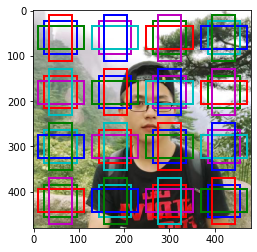

In [6]:
display_anchors(fmap_w=4, fmap_h=4, s=[0.15])

然后，我们将特征图的高度和宽度减小一半，然后使用较大的锚框来检测较大的目标。 当尺度设置为0.4时，一些锚框将彼此重叠。

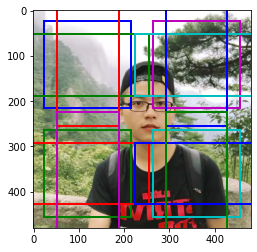

In [7]:
display_anchors(fmap_w=2, fmap_h=2, s=[0.4])

最后，我们进一步将特征图的高度和宽度减小一半，然后将锚框的尺度增加到0.8。 此时，锚框的中心即是图像的中心。

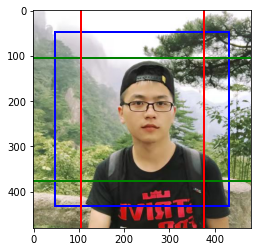

In [8]:
display_anchors(fmap_w=1, fmap_h=1, s=[0.8])